In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/nma.mplstyle")

import logging
logging.getLogger('matplotlib.font_manager').disabled = True

import ipywidgets as widgets  # interactive display
%config InlineBackend.figure_format = 'retina'

my_layout = widgets.Layout()

<h1 style="background-color:rgb(181 ,50 ,84);color:white;text-align:center">Synapses</h1>

We can describe the action of ligand gated ion channes in synapses through an explicitely time-dependend conductivity $g_{syn}(t)$ that will open whenever a presynaptic spike arrives. The current that passes through the synaptice channel is then given by $$I_{syn}(t) = g_{syn}(t)(u(t)-E_{syn})$$

Typically, a superposition of exponentials is used for $g_{syn}(t)$: $$g_{syn}(t) = \Sigma_f\overline{g}_{syn}e^{-\frac{t-t^{(f)}}{\tau}}\theta(t-t^{(f)})$$

Synaptic facilitation and depression can be modeled assuming the maximal synaptic conductance $\overline{g}_{syn}$ depends on the fraction $P_{rel}$ of available vesicles in the presynaptic terminal. The dynamics of $P_{rel}$ can be described by the following differential equation: $$\frac{dP_{rel}}{dt} = \frac{P_{rel}-P_0}{\tau_{P}} +f_F(1-P_{rel})\Sigma_f\delta(t-t^{(f)})$$ in the case of synaptic facilitation and $$\frac{dP_{rel}}{dt} = -\frac{P_{rel}-P_0}{\tau_{P}} -f_DP_{rel}\Sigma_f\delta(t-t^{(f)})$$ in the case of synaptic depression. Here, $P_0$ is the resting value of $P_{rel}$, $\tau_{P}$ is the time constant of the recovery from facilitation or depression, $f_F$ and $f_D$ are the facilitation and depression factors, respectively.

In [2]:
# typical neuron parameters
u_rest = -65.       # resting potential [mV]
tau_m = 10.         # membrane time constant [ms]
Cm = 1.0            # Membrane capacitance per unit area (uF/cm^2)
g_L = 10.           # leak conductance [nS]

gmax_Na = 120.      # Average sodium channel conductance per unit area (mS/cm^2)
gmax_K = 36.        # Average potassium channel conductance per unit area (mS/cm^2)
gmax_L = 0.3        # Average leak channel conductance per unit area (mS/cm^2)
ENa = 55.           # Sodium potential (mV)
EK = -77.           # Potassium potential (mV)
El = -65.           # Leak potential (mV)

g_syn0 = 40         # maximal synaptic conductance [pS]
ESyn_ex = 0.        # synaptic reversal potential for excitatory synapses [mV]
ESyn_in = -80.      # synaptic reversal potential for inhibitory synapses [mV]

P0 = 1
tau_P = 4
f_F = .5
tau_D = 7
f_D = .3

# Simulation parameters 
T = 40.              # Total duration of simulation [ms]
dt = .01             # Simulation time step [ms]

# Time vector
t = np.arange(0, T+dt, dt)

In [29]:
class SynapseModel():
    def __init__(self, u_rest, tau_m, Cm, g_L, El, 
        g_syn0, P0, f_F, tau_P, f_D, tau_D,
        tau_rise, tau_fast, tau_slow, a, Esyn
    ):
        self.u_rest = u_rest
        self.tau_m = tau_m
        self.Cm = Cm
        self.g_L = g_L
        self.EL = El
        self.g_syn0 = g_syn0
        self.P0 = P0
        self.f_F = f_F
        self.tau_P = tau_P
        self.f_D = f_D
        self.tau_D = tau_D
        self.tau_rise = tau_rise
        self.tau_fast = tau_fast
        self.tau_slow = tau_slow
        self.a = a
        self.Esyn = Esyn

    def P_rel(self, ti, rec_spikes):
        P_rel = self.P0

        for spike in rec_spikes:
            if ti > spike:
                P_rel += self.f_F * np.exp(-(ti - spike) / self.tau_P) - self.f_D * np.exp(-(ti - spike) / self.tau_D)

        return P_rel

    def gbar_syn(self, ti, rec_spikes):
        return self.g_syn0 * self.P_rel(ti, rec_spikes)

    def g_syn(self, ti, rec_spikes):
        g_syn = 0

        for spike in rec_spikes:
            if ti > spike:
                g_syn += self.gbar_syn(ti, rec_spikes) * (1 - np.exp(-(ti - spike) / self.tau_rise)) * (self.a * np.exp(-(ti - spike) / self.tau_fast) + (1 - self.a) * np.exp(-(ti - spike) / self.tau_slow))
        
        return g_syn

    def Isyn(self, u, ti, rec_spikes):
        return self.g_syn(ti, rec_spikes) * (u - self.Esyn)

    def IL(self, u):
        return self.g_L * (u - self.EL)

    def u_dot(self, u, ti, rec_spikes):
            return (- self.Isyn(u, ti, rec_spikes) - self.IL(u)) / self.Cm

    def simulate(self, t_range, dt, rec_spikes):
        u_t = np.zeros_like(t_range)
        u_t[0] = self.u_rest
        
        for i in range(len(t_range) - 1):
            u_t[i+1] = u_t[i] + dt * self.u_dot(u_t[i], t_range[i], rec_spikes)

        return u_t

    def plot_state(self, t_range, u_t, rec_spikes, title='Synapse model'):
        fig, ax = plt.subplots(1, 3, figsize=(9, 3))
        fig.suptitle(title, fontsize=16, fontweight='bold', y=.9, color='blue')

        # membrane potential
        ax[0].plot(t_range, u_t, label='u')
        ax[0].vlines(rec_spikes, np.min(u_t), np.max(u_t), color='r', linestyle='dashed', label='spike')
        ax[0].set_title('Membrane potential')
        ax[0].set_xlabel('Time [ms]')
        ax[0].set_ylabel('u [mV]')
        ax[0].legend()

        # synaptic conductance
        g_syn = [self.g_syn(ti, rec_spikes) for ti in t_range]
        ax[1].plot(t_range, g_syn, label='g_syn')
        ax[1].set_title('Synaptic conductance')
        ax[1].set_xlabel('Time [ms]')
        ax[1].set_ylabel('g_syn [pS]')
        ax[1].legend()

        # synaptic current
        I_syn = [-self.Isyn(u, ti, rec_spikes) for u, ti in zip(u_t, t_range)]
        ax[2].plot(t_range, I_syn, label='I_syn')
        ax[2].set_title('Synaptic current')
        ax[2].set_xlabel('Time [ms]')
        ax[2].set_ylabel('I_syn [nA]')
        ax[2].legend()

        plt.show()            

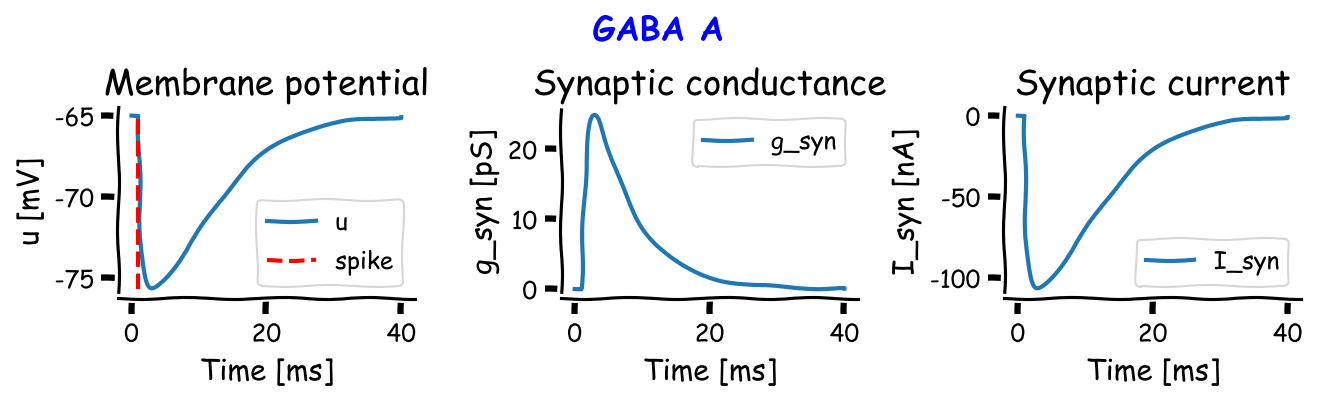

In [30]:
### GABA_A receptors - no short-term plasticity

rec_spikes = np.array([1])

GABA_A = SynapseModel(u_rest, tau_m, Cm, g_L, El, g_syn0, P0, 0, tau_P, 0, tau_D, 1, 6, 100, 1, ESyn_in)
u_t = GABA_A.simulate(t, dt, rec_spikes)

# Plot the results
with plt.xkcd():
    GABA_A.plot_state(t, u_t, rec_spikes, 'GABA A')

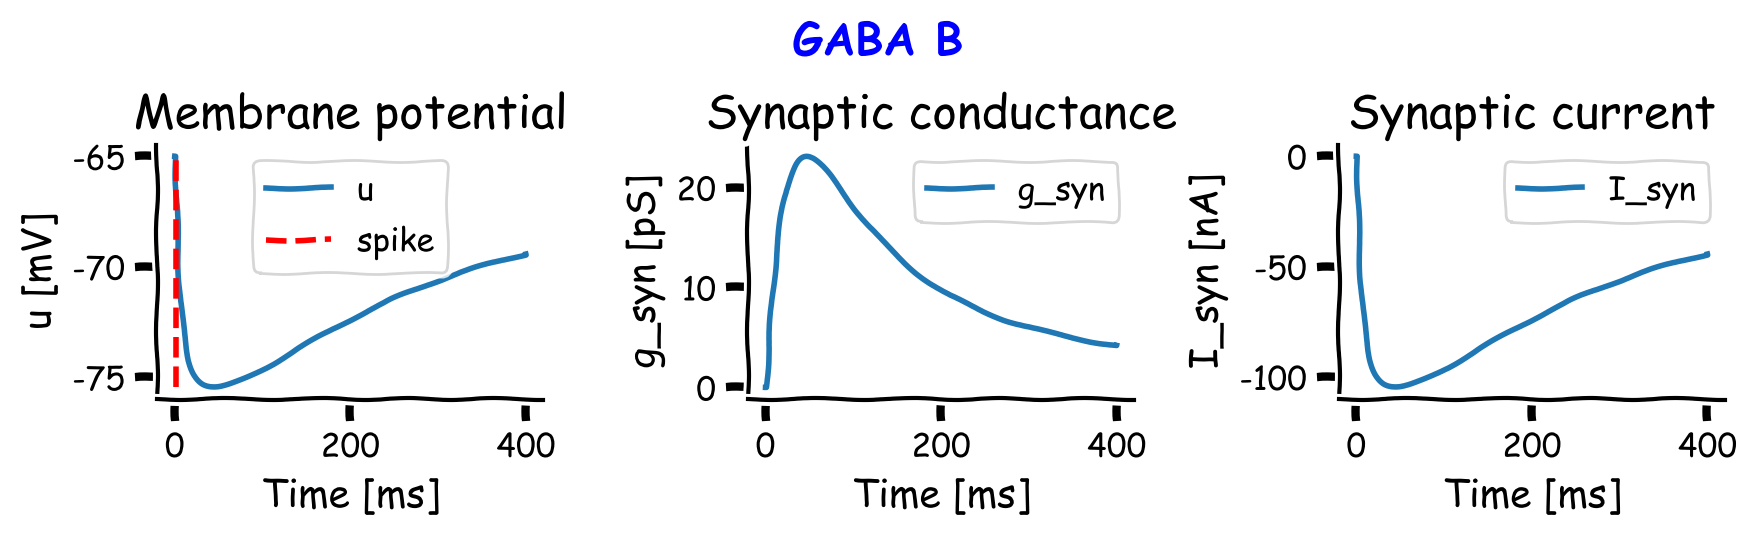

In [8]:
### GABA_B receptors - no short-term plasticity

rec_spikes = np.array([1])
t = np.arange(0, 400, 0.01)

GABA_B = SynapseModel(u_rest, tau_m, Cm, g_L, El, g_syn0, P0, 0, tau_P, 0, tau_D, 25, 100, 500, 0.8, ESyn_in)
u_t = GABA_B.simulate(t, dt, rec_spikes)

# Plot the results
with plt.xkcd():
    GABA_B.plot_state(t, u_t, rec_spikes, 'GABA B')

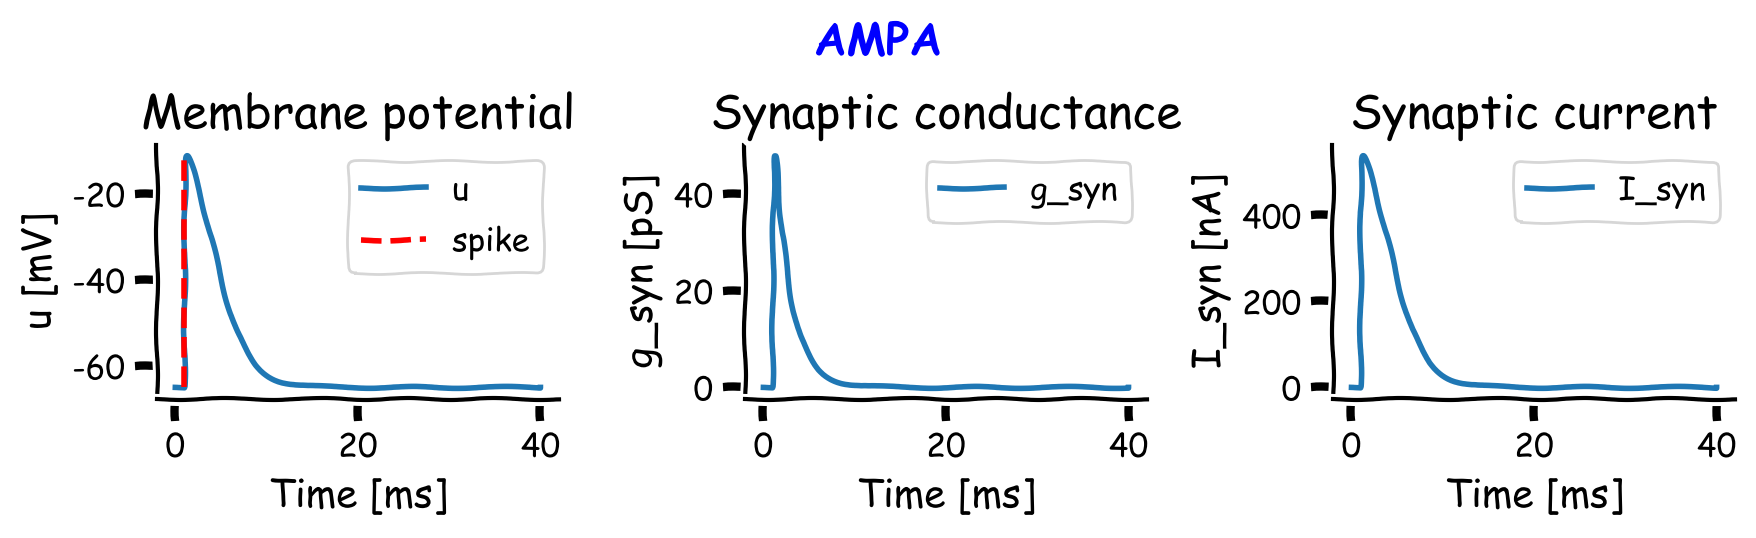

In [18]:
### AMPA receptors - no short-term plasticity

rec_spikes = np.array([1])
t = np.arange(0, 40, 0.001)

AMPA = SynapseModel(u_rest, tau_m, Cm, g_L, El, g_syn0, P0, f_F, tau_P, 0, tau_D, 0.1, 2, 100, 1, ESyn_ex)
u_t = AMPA.simulate(t, dt, rec_spikes)

# Plot the results
with plt.xkcd():
    AMPA.plot_state(t, u_t, rec_spikes, 'AMPA')

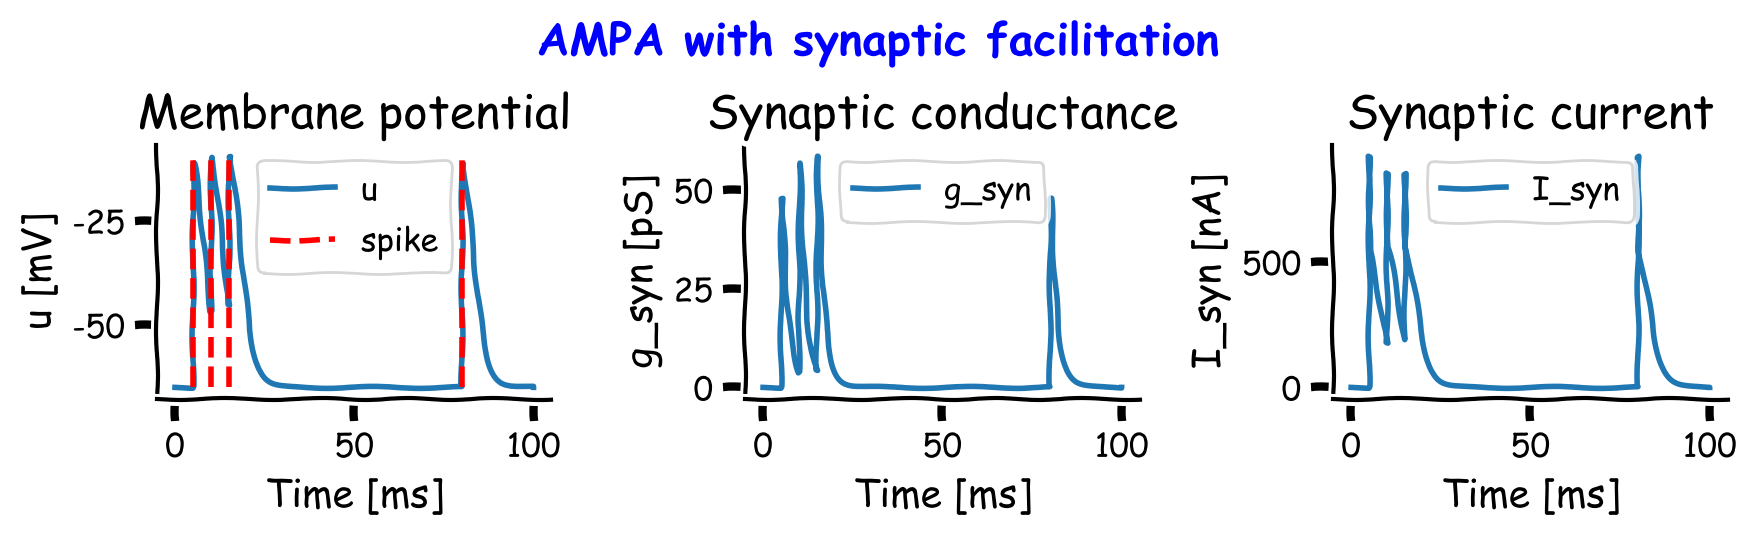

In [7]:
### AMPA receptors - synaptic facilitation

t = np.arange(0, 100+dt, dt)
rec_spikes = np.array([5, 10, 15, 80])

AMPA = SynapseModel(u_rest, tau_m, Cm, g_L, El, g_syn0, P0, f_F, tau_P, 0, tau_D, 0.1, 2, 100, 1, ESyn_ex)
u_t = AMPA.simulate(t, dt, rec_spikes)

# Plot the results
with plt.xkcd():
    AMPA.plot_state(t, u_t, rec_spikes, 'AMPA with synaptic facilitation')

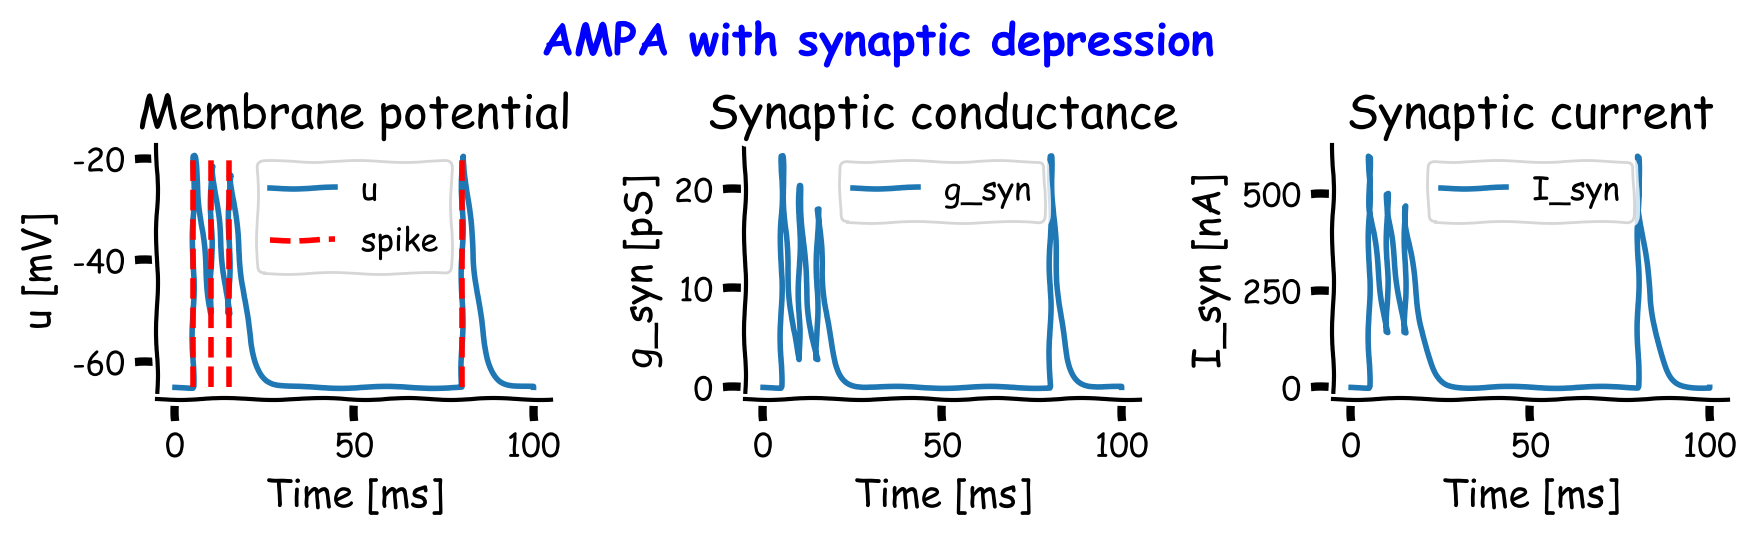

In [8]:
### AMPA receptors - synaptic depression

t = np.arange(0, 100+dt, dt)
rec_spikes = np.array([5, 10, 15, 80])

AMPA = SynapseModel(u_rest, tau_m, Cm, g_L, El, g_syn0, P0, 0, tau_P, f_D, tau_D, 0.1, 2, 100, 1, ESyn_ex)
u_t = AMPA.simulate(t, dt, rec_spikes)

# Plot the results
with plt.xkcd():
    AMPA.plot_state(t, u_t, rec_spikes, 'AMPA with synaptic depression')

<h1 style="background-color:rgb(181 ,50 ,84);color:white;text-align:center">Dendrites - cable equation</h1>

Unit free cable equation for passive dendrite: $$\frac{\partial}{\partial t}u(t,x) = \frac{\partial^2}{\partial x^2}u(t,x)-u(t,x)+i_{ext}(t,x)$$

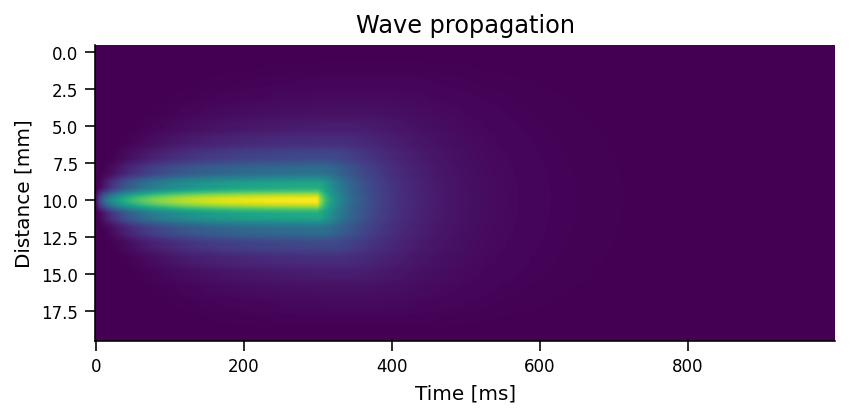

In [26]:
dx = 0.5
dt = 0.01

x_range = np.arange(0, 10, dx)
t_range = np.arange(0, 10, dt)

x_half = len(x_range) // 2

X = np.zeros((len(x_range), len(t_range)))

u_dot = lambda um, u, up, i_ext, dx: (um - 2*u + up) / dx**2 - u + i_ext

X[0, :] = 0

i_ext = np.zeros_like(X)
i_ext[x_half, :300] = 100


for j in range(len(t_range) - 1):
    for i in range(1, len(x_range) - 1):
        X[i, j+1] = X[i, j] + dt*u_dot(X[i-1, j], X[i, j], X[i+1, j], i_ext[i, j], dx)


fig, ax = plt.subplots(1, 1, figsize=(6, 3))
ax.imshow(X, aspect='auto', cmap='viridis')
ax.set_title('Wave propagation')
ax.set_xlabel('Time [ms]')
ax.set_ylabel('Distance [mm]')
plt.show()

In [33]:
# Create a slider to move through time
time_slider = widgets.IntSlider(value=0, min=0, max=len(t_range)-1, step=1, description='Time', style={'description_width': 'initial'}, layout=my_layout)

def plot_wave(time):
    fig, ax = plt.subplots(1, 1, figsize=(6, 3))
    ax.plot(x_range, X[:, time])
    plt.ylim(0, 10)
    ax.set_title('Wave propagation')
    ax.set_xlabel('Distance [mm]')
    ax.set_ylabel('u')
    plt.show()

widgets.interactive(plot_wave, time=time_slider)

interactive(children=(IntSlider(value=0, description='Time', max=999, style=SliderStyle(description_width='ini…